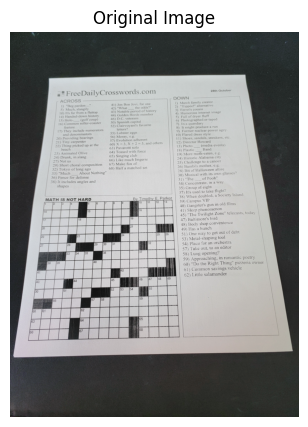

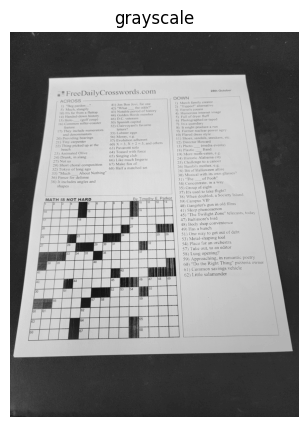

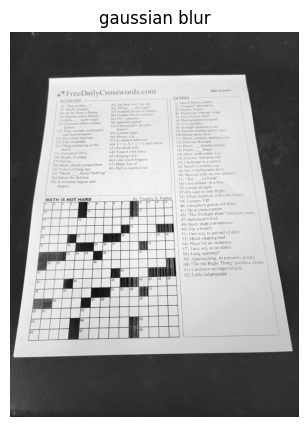

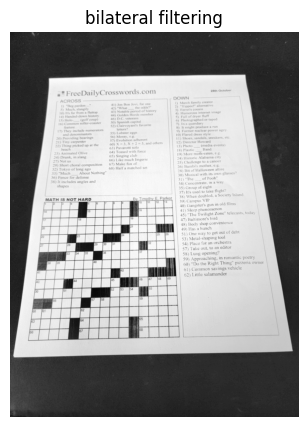

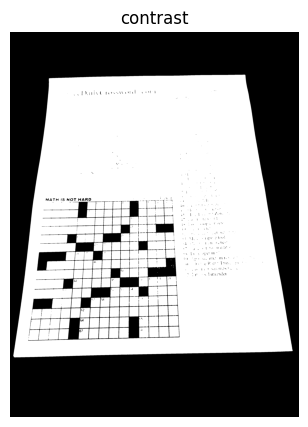

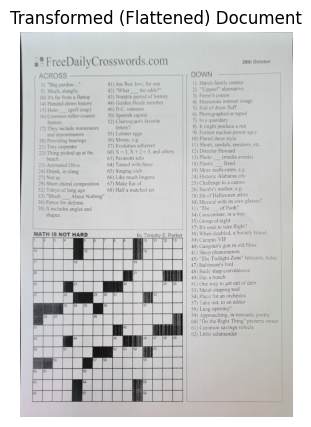

In [10]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pytesseract
import re
import json
from ImageProcessing import * 


# Currently works for image E 
def show_img(img, title):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis('off') 

#Set the URL of the server
url = "http://127.0.0.1:5000/"  # Make sure this matches your Flask app's URL

#Path to the image file on your local disk
image_path = "Testing/crosswordE.jpg"


#Load the original image using OpenCV (to display it)
orig = cv2.imread(image_path)

#Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(orig)
plt.axis('off')  # Hide axes

def preprocess(): 
    """
    Applies steps to make an image ready for crossword solving:
    
    1. Converts the original image to grayscale.
    2. Applies Gaussian blur to reduce noise.
    3. Uses bilateral filtering to further smooth the image while preserving edges.
    4. Enhances contrast with binary thresholding.
    5. Performs edge detection using the Canny algorithm.
    6. Finds contours in an image to find the 4 corners representing the document. 
    
    Each intermediate image is displayed with a descriptive title.
    """
    # Grayscale 
    grayscale = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    show_img(grayscale, "grayscale")

    # Gaussian Blur 
    gauss = cv2.GaussianBlur(grayscale, (5,5), 0)
    show_img(gauss, "gaussian blur")
    # Bilateral Filtering
    bilat = cv2.bilateralFilter(gauss,9,75,75)
    show_img(bilat, "bilateral filtering")
    # Contrast 
    _, thresh = cv2.threshold(bilat, 128, 255, cv2.THRESH_BINARY)
    show_img(thresh, "contrast")

    # Edge Detection 
    edges = cv2.Canny(thresh, 150, 150)

    # Contours 
    corners = find_contours(edges)

    if corners is None:
        print("No contour with 4 corners found.")
        return jsonify({"error": "Document edges not detected"}), 400

    contours = orig.copy()
    cv2.drawContours(contours, [corners], -1, (0, 255, 0), 3)

    # top left, top right, bottom left, bottom right
    dst_points = np.float32([[2480, 0], [0, 0], [0, 3508], [2480, 3508]])
    matrix = cv2.getPerspectiveTransform(np.float32(corners), dst_points)
    transformed = cv2.warpPerspective(orig, matrix, (2480, 3500))
    show_img(transformed, "Transformed (Flattened) Document")
    cv2.imwrite("transformed.png", transformed)
    return transformed



img = preprocess()



In [15]:
import requests
import urllib
from bs4 import BeautifulSoup

#Define the base URL where we will be posting a request
url = "https://www.dictionary.com/e/crosswordsolver/"

#Modify URL and parameters based on clues (example here)
url = url + "Beg-pardon-.../"

parameters = {
    "p": "????",  # The pattern of letters for the crossword
    "l": 4        # The expected length of the word
}

#Send GET request with the encoded parameters
response = requests.get(url + f"?{urllib.parse.urlencode(parameters)}")

#Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')

#Find all rows with possible answers
    rows = soup.find_all('div', class_='solver-table__row')

#Initialize a list to store the answers
    answers = []

    # Iterate through the rows and extract the answer and confidence
    for row in rows:
        # Find the div with data-cy="result" to get the answer
        answer_cell = row.find('div', attrs={'data-cy': 'result'})
        if answer_cell:
            answer = answer_cell.text.strip()  # Clean up the answer text
            answers.append(answer)

#Print or process the answers list
    print("Possible Answers:", answers)

else:
    print("Error: Unable to fetch results.")

Possible Answers: ['AHEM', 'WHAT', 'ISAY', 'IBEG', 'AINT', 'VERB', 'PRIE', 'ESPN', 'AGOD']
